In [82]:
# Question: Can the trends of champion bans be used to identify when matches occured?

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sc
from scipy.stats import bernoulli, binom, norm
from scipy.stats import chi2_contingency # chi-sqaured
from scipy.stats import pearsonr # pearson correlation
from scipy.stats import spearmanr # spearman correlation

import statsmodels.formula.api as smf

# use to cut up strings
import re

import numpy as np
import pandas as pd

In [83]:
df = pd.read_csv('https://raw.githubusercontent.com/harsh1399/DS2500-Data_Wrangling/refs/heads/main/Module_Assignment-2/League-of-Legends/bans.csv')

In [84]:
# read LoL champions stats
LOLdf = pd.read_csv('LOL_champions_stats.csv', sep=";", encoding='latin-1')


In [85]:
df.shape

(15240, 7)

In [86]:
df.head()

,Address,Team,ban_1,ban_2,ban_3,ban_4,ban_5
0,http://matchhistory.na.leagueoflegends.com/en/...,blueBans,Rumble,Kassadin,Lissandra,NaN,NaN
1,http://matchhistory.na.leagueoflegends.com/en/...,blueBans,Kassadin,Sivir,Lissandra,NaN,NaN
2,http://matchhistory.na.leagueoflegends.com/en/...,blueBans,JarvanIV,Lissandra,Kassadin,NaN,NaN
3,http://matchhistory.na.leagueoflegends.com/en/...,blueBans,Annie,Lissandra,Kassadin,NaN,NaN
4,http://matchhistory.na.leagueoflegends.com/en/...,blueBans,Irelia,Pantheon,Kassadin,NaN,NaN


In [87]:
df.tail()

,Address,Team,ban_1,ban_2,ban_3,ban_4,ban_5
15235,https://matchhistory.euw.leagueoflegends.com/e...,redBans,Ornn,Kalista,Ryze,Alistar,Shen
15236,https://matchhistory.euw.leagueoflegends.com/e...,redBans,Zoe,KogMaw,JarvanIV,Ornn,Rengar
15237,https://matchhistory.na.leagueoflegends.com/en...,redBans,Azir,Kalista,Braum,Maokai,Alistar
15238,https://matchhistory.na.leagueoflegends.com/en...,redBans,Kalista,Galio,Gnar,Jayce,Sejuani
15239,https://matchhistory.na.leagueoflegends.com/en...,redBans,KogMaw,Illaoi,Azir,Karma,Sejuani


In [88]:
# check LOLdf
LOLdf.head()

,champion_name,champion_title,class,playstyle,date_release,last_change,blue_essence_price,rp_price,ressource,HP,...,AR,AR+,AR_lvl18,MR,MR+,MR_lvl18,MS,MS_lvl18,range,range_lvl18
0,Aatrox,the Darkin Blade,Fighter,Juggernaut,13/06/2013,V11.2,4800,880,Blood Well,580.0,...,38.0,3.25,93.25,32.0,1.25,53.25,345,345,175,175
1,Ahri,the Nine-Tailed Fox,Mage,Burst,14/12/2011,V11.1,3150,790,Mana,526.0,...,21.0,3.50,80.50,30.0,0.50,38.50,330,330,550,550
2,Akali,the Rogue Assassin,Slayer,Assassin,11/05/2010,V11.10,3150,790,Energy,500.0,...,23.0,3.50,82.50,37.0,1.25,58.25,345,345,125,125
3,Alistar,the Minotaur,Tank,Vanguard,21/02/2009,V11.8,1350,585,Mana,600.0,...,44.0,3.50,103.50,32.0,1.25,53.25,330,330,125,125
4,Amumu,the Sad Mummy,Tank,Vanguard,26/06/2009,V11.7,450,260,Mana,615.0,...,30.0,3.80,94.60,32.0,1.25,53.25,335,335,125,125


In [89]:
LOLdf.tail()

,champion_name,champion_title,class,playstyle,date_release,last_change,blue_essence_price,rp_price,ressource,HP,...,AR,AR+,AR_lvl18,MR,MR+,MR_lvl18,MS,MS_lvl18,range,range_lvl18
152,Zed,the Master of Shadows,Slayer,Assassin,13/11/2012,V11.8,4800,880,Energy,584.0,...,32.0,3.5,91.5,32.0,1.25,53.25,345,345,125,125
153,Ziggs,the Hexplosives Expert,Mage Artillery,Artillery,01/02/2012,V11.1,4800,880,Mana,536.0,...,22.0,3.3,78.1,30.0,0.50,38.50,325,325,550,550
154,Zilean,the Chronokeeper,Specialist,Specialist,18/04/2009,V11.1,1350,585,Mana,504.0,...,24.0,3.8,88.6,30.0,0.50,38.50,335,335,550,550
155,Zoe,the Aspect of Twilight,Mage,Burst,21/11/2017,V11.2,6300,975,Mana,560.0,...,21.0,3.5,80.5,30.0,0.50,38.50,340,340,550,550
156,Zyra,Rise of the Thorns,Controller,Catcher,24/07/2012,V11.10,4800,880,Mana,504.0,...,29.0,3.0,80.0,30.0,0.50,38.50,340,340,575,575


In [90]:
# check for empty cells
df.isnull().sum()
df.isna().sum()

Address       0
Team          0
ban_1        48
ban_2        59
ban_3       139
ban_4      8276
ban_5      8362
dtype: int64

In [91]:
# replace na with "noBan" to represent that a team chose not to ban a champion, 
# the reason these are all twoards the end of the CSV is because None bans happen when a player runs out of time to choose a ban
df.fillna("noBan", inplace=True)

In [92]:
# get all unique names of banned characters
banned_1_unique = df['ban_1'].unique()
banned_2_unique = df['ban_2'].unique()
banned_3_unique = df['ban_3'].unique()
banned_4_unique = df['ban_4'].unique()
banned_5_unique = df['ban_5'].unique()

# replace 'FiddleSticks' because its a captitalization variant of 'Fiddlesticks'
df.replace('FiddleSticks', 'Fiddlesticks', inplace=True)

# contatenate all unique names of banned characters
banned_unique = np.concatenate([banned_1_unique, banned_2_unique, banned_3_unique, banned_4_unique, banned_5_unique])

# eliminate duplicates
banned_champs = np.unique(banned_unique)

print(banned_champs)

['Aatrox' 'Ahri' 'Akali' 'Alistar' 'Amumu' 'Anivia' 'Annie' 'Ashe'
 'AurelionSol' 'Azir' 'Bard' 'Blitzcrank' 'Brand' 'Braum' 'Caitlyn'
 'Camille' 'Cassiopeia' 'Chogath' 'Corki' 'Darius' 'Diana' 'DrMundo'
 'Draven' 'Ekko' 'Elise' 'Evelynn' 'Ezreal' 'FiddleSticks' 'Fiddlesticks'
 'Fiora' 'Fizz' 'Galio' 'Gangplank' 'Garen' 'Gnar' 'Gragas' 'Graves'
 'Hecarim' 'Heimerdinger' 'Illaoi' 'Irelia' 'Ivern' 'Janna' 'JarvanIV'
 'Jax' 'Jayce' 'Jhin' 'Jinx' 'Kalista' 'Karma' 'Karthus' 'Kassadin'
 'Katarina' 'Kayle' 'Kayn' 'Kennen' 'Khazix' 'Kindred' 'Kled' 'KogMaw'
 'Leblanc' 'LeeSin' 'Leona' 'Lissandra' 'Lucian' 'Lulu' 'Lux' 'Malphite'
 'Malzahar' 'Maokai' 'MasterYi' 'MissFortune' 'Mordekaiser' 'Morgana'
 'Nami' 'Nasus' 'Nautilus' 'Nidalee' 'Nocturne' 'Nunu' 'Olaf' 'Orianna'
 'Ornn' 'Pantheon' 'Poppy' 'Quinn' 'Rakan' 'Rammus' 'RekSai' 'Renekton'
 'Rengar' 'Riven' 'Rumble' 'Ryze' 'Sejuani' 'Shaco' 'Shen' 'Shyvana'
 'Singed' 'Sion' 'Sivir' 'Skarner' 'Sona' 'Soraka' 'Swain' 'Syndra'
 'TahmKench' 'Taliy

In [93]:
# check which champions are not included in the ban list
all_champs = LOLdf['champion_name'].unique()
not_banned = list(set(all_champs) - set(banned_champs))
print(not_banned)

['Kaisa', 'Aurelion Sol', 'Dr. Mundo', 'Xin Zhao', 'Samira', 'VelKoz', 'Miss Fortune', 'LeBlanc', 'Lillia', 'Tryndamere', 'Master Yi', 'Sï¿½raphine', 'Yone', 'Rell', 'Kled & Skarl', 'Sylas', 'Jarvan IV', 'Viego', 'Yuumi', 'Wukong', 'Gwen', 'Teemo', 'KhaZix', 'Twisted Fate', 'Gnar Mega', 'Senna', 'Qiyana', 'Pyke', 'Aphelios', 'Tahm Kench', 'Sett', 'Neeko', 'Lee Sin']


In [94]:
# check number of champions banned
len(banned_champs)

# as of July 2024 there are 168 champions. Leageu of legends usually introduced 4-5 champions per year. 
# all names in the list are champions
# So this number of banned champions (which may exclude unpopular champions) is reasonable

138

In [95]:
# find the newest banned champion
# replace the / in date_release with - to fulfill .to_datetime() requirements
LOLdf['date_release'] = LOLdf['date_release'].replace('/', '-')

# convert to datetime
LOLdf['date_release'] = pd.to_datetime(LOLdf['date_release'])

# find the newest champion in the banned list
banned_champs_df = pd.DataFrame(banned_champs, columns=['champion_name'])
banned_champs_df = banned_champs_df.merge(LOLdf[['champion_name', 'date_release']], on='champion_name', how='left')

newest_champ = banned_champs_df['date_release'].max()
newest_champ

# the newest champion in the banned list is Zoe, released 2017-11-21. This gives an indication of when the data was collected
# The games likely occured after 2017-11-21 but before another meta-defining champion was released, giving a 3-12 month window for the games to occur

C:\Users\clair\AppData\Local\Temp\ipykernel_64728\3542110629.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  LOLdf['date_release'] = pd.to_datetime(LOLdf['date_release'])


Timestamp('2017-11-21 00:00:00')

In [96]:
# clean up the URLS (no longer usable since Riot Games shut down the match history API)
df['Address'] = df['Address'].str.replace('https://matchhistory','')

In [97]:
# identify a '/' follwed by a sequence of digits ended with ?
df['URL_num'] = df['Address'].str.extract(r'\/(\d+)\?')

# check URL_num in df, verify that it was properly extracted
df.head()
df.tail()

,Address,Team,ban_1,ban_2,ban_3,ban_4,ban_5,URL_num
15235,.euw.leagueoflegends.com/en/#match-details/ESP...,redBans,Ornn,Kalista,Ryze,Alistar,Shen,530658
15236,.euw.leagueoflegends.com/en/#match-details/ESP...,redBans,Zoe,KogMaw,JarvanIV,Ornn,Rengar,530666
15237,.na.leagueoflegends.com/en/#match-details/ESPO...,redBans,Azir,Kalista,Braum,Maokai,Alistar,520894
15238,.na.leagueoflegends.com/en/#match-details/ESPO...,redBans,Kalista,Galio,Gnar,Jayce,Sejuani,520895
15239,.na.leagueoflegends.com/en/#match-details/ESPO...,redBans,KogMaw,Illaoi,Azir,Karma,Sejuani,520903


In [98]:
#identify the Server of match by using a pattern to extract the capitalized string
df['Server'] = df['Address'].str.extract(r'#match-details/([A-Z0-9]+)/')

# NA (TRNA1) - North America
# KR (TRKR) - Korea
# EUW (TREUW) - Europe West

# instantiate top_bans
top_bans = []

# check Server in df, verify that it was properly extracted
df.head()
df.tail()

,Address,Team,ban_1,ban_2,ban_3,ban_4,ban_5,URL_num,Server
15235,.euw.leagueoflegends.com/en/#match-details/ESP...,redBans,Ornn,Kalista,Ryze,Alistar,Shen,530658,ESPORTSTMNT03
15236,.euw.leagueoflegends.com/en/#match-details/ESP...,redBans,Zoe,KogMaw,JarvanIV,Ornn,Rengar,530666,ESPORTSTMNT03
15237,.na.leagueoflegends.com/en/#match-details/ESPO...,redBans,Azir,Kalista,Braum,Maokai,Alistar,520894,ESPORTSTMNT03
15238,.na.leagueoflegends.com/en/#match-details/ESPO...,redBans,Kalista,Galio,Gnar,Jayce,Sejuani,520895,ESPORTSTMNT03
15239,.na.leagueoflegends.com/en/#match-details/ESPO...,redBans,KogMaw,Illaoi,Azir,Karma,Sejuani,520903,ESPORTSTMNT03


In [99]:
# NA (TRNA1) - North America
# KR (TRKR) - Korea
# EUW (TREUW) - Europe West

# I should not have used a lambda but I wasnt sure how else to do it efficiently

df['Region'] = df['Server'].apply(lambda x: 'North America' if 'NA' in x else ('Korea' if 'KR' in x else ('Europe West' if 'EUW' in x else ('Brazil' if 'BR' in x else ('Europe East' if 'EUNE' in x else ('Latin America North' if 'LAN' in x else ('Latin America South' if 'LAS' in x else ('Oceania' if 'OCE' in x else ('Russia' if 'RU' in x else ('Japan' if 'JP' in x else ('Middle East' if 'ME' in x else ('Phillippines' if 'PH' in x else ('Singapore/Malaysia/Indonesia' if 'SG' in x else ('Taiwan/HC/Macao' if 'TW' in x else ('Local Host' if 'LH' in x else ('Thailand' if 'TH' in x else ('Turkey' if 'TR' in x else ('Public Beta Environment' if 'PBE' in x else ('ESports' if 'ES' in x else 'Unknown')))))))))))))))))))

regions = df['Region'].unique()

# check Region in df
df

,Address,Team,ban_1,ban_2,ban_3,ban_4,ban_5,URL_num,Server,Region
0,http://matchhistory.na.leagueoflegends.com/en/...,blueBans,Rumble,Kassadin,Lissandra,noBan,noBan,30030,TRLH1,Local Host
1,http://matchhistory.na.leagueoflegends.com/en/...,blueBans,Kassadin,Sivir,Lissandra,noBan,noBan,30054,TRLH1,Local Host
2,http://matchhistory.na.leagueoflegends.com/en/...,blueBans,JarvanIV,Lissandra,Kassadin,noBan,noBan,30067,TRLH1,Local Host
3,http://matchhistory.na.leagueoflegends.com/en/...,blueBans,Annie,Lissandra,Kassadin,noBan,noBan,30091,TRLH1,Local Host
4,http://matchhistory.na.leagueoflegends.com/en/...,blueBans,Irelia,Pantheon,Kassadin,noBan,noBan,30105,TRLH1,Local Host
...,...,...,...,...,...,...,...,...,...,...
15235,.euw.leagueoflegends.com/en/#match-details/ESP...,redBans,Ornn,Kalista,Ryze,Alistar,Shen,530658,ESPORTSTMNT03,ESports
15236,.euw.leagueoflegends.com/en/#match-details/ESP...,redBans,Zoe,KogMaw,JarvanIV,Ornn,Rengar,530666,ESPORTSTMNT03,ESports
15237,.na.leagueoflegends.com/en/#match-details/ESPO...,redBans,Azir,Kalista,Braum,Maokai,Alistar,520894,ESPORTSTMNT03,ESports
15238,.na.leagueoflegends.com/en/#match-details/ESPO...,redBans,Kalista,Galio,Gnar,Jayce,Sejuani,520895,ESPORTSTMNT03,ESports


<Axes: xlabel='Region'>

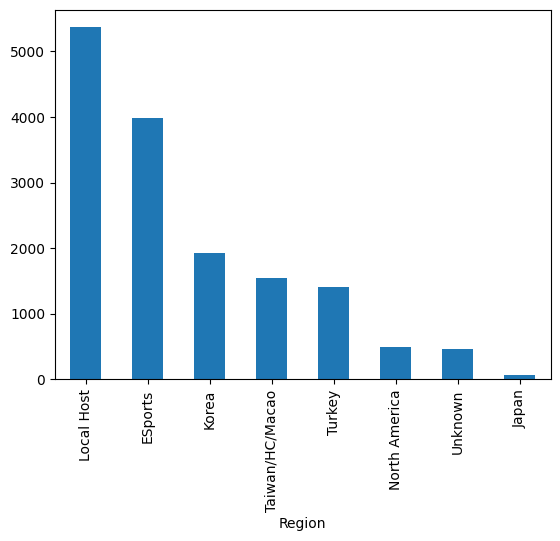

In [100]:
# count number of matches from each region 
df['Region'].value_counts().plot(kind ='bar')

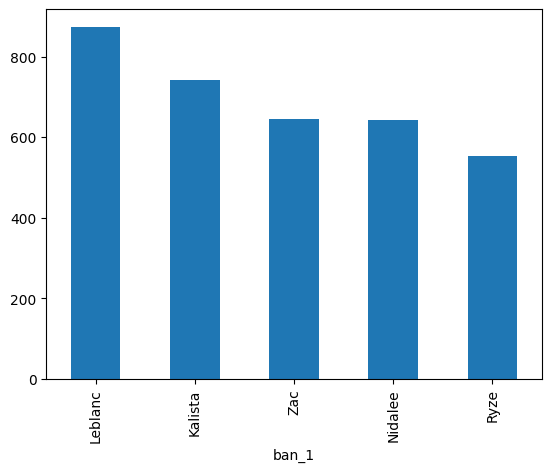

In [101]:
# create histogram of strings in ban_1
df[df['ban_1'] != 'noBan']['ban_1'].value_counts().head().plot(kind='bar')

top_bans.extend(df['ban_1'].value_counts().head(10).index)

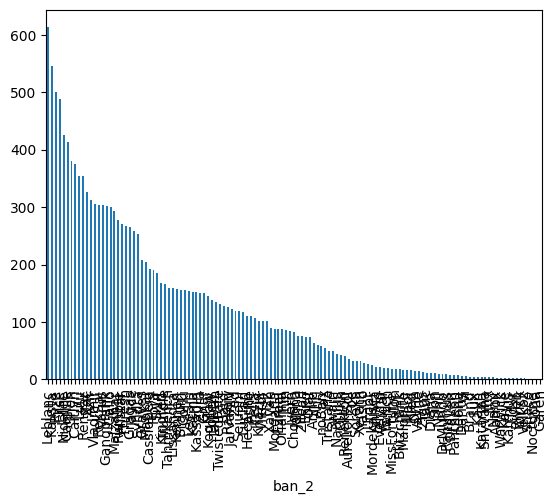

In [102]:
# bar chart of strings in ban_2
df['ban_2'].value_counts().plot(kind='bar')

top_bans.extend(df['ban_2'].value_counts().head(10).index)

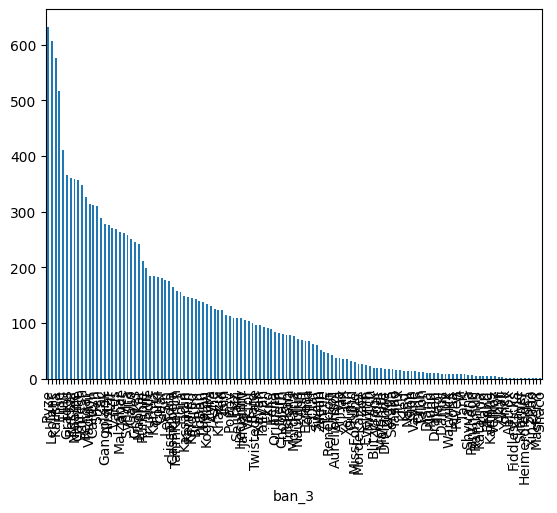

In [103]:
# bar chart of strings in ban_3
df['ban_3'].value_counts().plot(kind='bar')

top_bans.extend(df['ban_3'].value_counts().head(10).index)

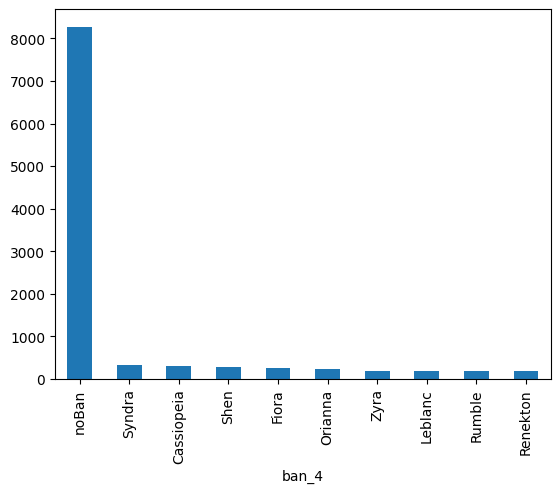

In [104]:
# bar chart of strings in ban_4
df['ban_4'].value_counts().head(10).plot(kind='bar')

top_bans.extend(df['ban_4'].value_counts().head(10).index)

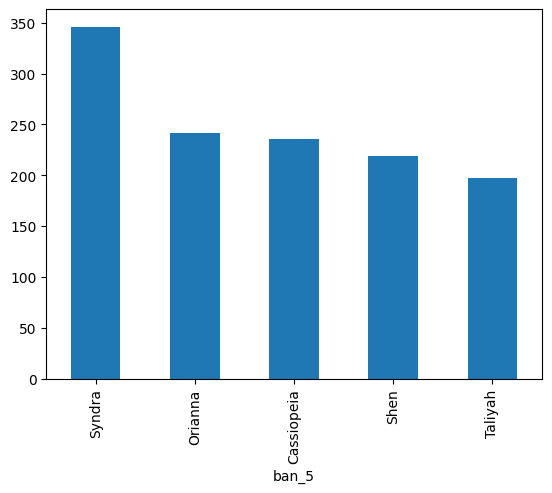

In [105]:
# bar chart of strings in ban_5
df[df['ban_5'] != 'noBan']['ban_5'].value_counts().head().plot(kind='bar')

top_bans.extend(df['ban_5'].value_counts().head(10).index)

In [106]:
top_bans = np.unique(top_bans)
top_bans = top_bans[top_bans != 'noBan']

print(top_bans)

['Azir' 'Caitlyn' 'Camille' 'Cassiopeia' 'Elise' 'Fiora' 'Gragas' 'Jayce'
 'Kalista' 'Leblanc' 'Lulu' 'Nidalee' 'Orianna' 'RekSai' 'Renekton'
 'Rengar' 'Rumble' 'Ryze' 'Shen' 'Syndra' 'Taliyah' 'Thresh' 'Zac' 'Zyra']


<Axes: xlabel='ban_1'>

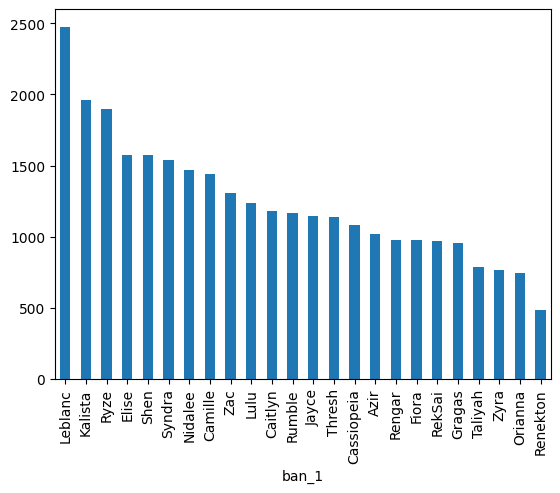

In [107]:
# bar chart of top_bans for the top_bans names
ban1_counts = df['ban_1'].value_counts().loc[top_bans]
ban2_counts = df['ban_2'].value_counts().loc[top_bans]
ban3_counts = df['ban_3'].value_counts().loc[top_bans]
ban4_counts = df['ban_4'].value_counts().loc[top_bans]
ban5_counts = df['ban_5'].value_counts().loc[top_bans]

top_ban_data = ban1_counts.add(ban2_counts, fill_value=0).add(ban3_counts, fill_value=0).add(ban4_counts, fill_value=0).add(ban5_counts, fill_value=0)

top_ban_data.sort_values(ascending=False).plot(kind='bar')

In [108]:
#with each instance of a ban in ban_1, ban_2, etc, add a row to a new dataframe with the Server, df index, and the character banned associated with that ban

df['og_index'] = df.index

ban_columns = ['ban_1', 'ban_2', 'ban_3', 'ban_4', 'ban_5']

melted_df = df.melt(id_vars=['Server', 'og_index', 'Region', 'URL_num'], value_vars=ban_columns, var_name='Ban', value_name='Champion')

ban_data = melted_df[[ 'og_index', 'Champion', 'Server', 'Region', 'URL_num']]

ban_data

# it appears that it is grabbing all the ban_1 data, then all the ban_2 data, etc.

ban_data.sort_values(by='og_index')

,og_index,Champion,Server,Region,URL_num
0,0,Rumble,TRLH1,Local Host,30030
45720,0,noBan,TRLH1,Local Host,30030
30480,0,Lissandra,TRLH1,Local Host,30030
60960,0,noBan,TRLH1,Local Host,30030
15240,0,Kassadin,TRLH1,Local Host,30030
...,...,...,...,...,...
60959,15239,Karma,ESPORTSTMNT03,ESports,520903
30479,15239,Illaoi,ESPORTSTMNT03,ESports,520903
15239,15239,KogMaw,ESPORTSTMNT03,ESports,520903
45719,15239,Azir,ESPORTSTMNT03,ESports,520903


In [109]:
# impute missing values in URL_num
while ban_data['URL_num'].isnull().sum() > 0:
    ban_data['URL_num'] = ban_data['URL_num'].astype('float')
    ban_data['URL_num'] = ban_data['URL_num'].fillna(ban_data['URL_num'].shift(-1) + 1)

# print URL_num to check that it was imputed
print(ban_data['URL_num'])
ban_data['URL_num'].isnull().sum()


0         30030.0
1         30054.0
2         30067.0
3         30091.0
4         30105.0
           ...   
76195    530658.0
76196    530666.0
76197    520894.0
76198    520895.0
76199    520903.0
Name: URL_num, Length: 76200, dtype: float64


C:\Users\clair\AppData\Local\Temp\ipykernel_64728\3041425349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ban_data['URL_num'] = ban_data['URL_num'].astype('float')
C:\Users\clair\AppData\Local\Temp\ipykernel_64728\3041425349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ban_data['URL_num'] = ban_data['URL_num'].fillna(ban_data['URL_num'].shift(-1) + 1)
C:\Users\clair\AppData\Local\Temp\ipykernel_64728\3041425349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

0

<Axes: xlabel='Region'>

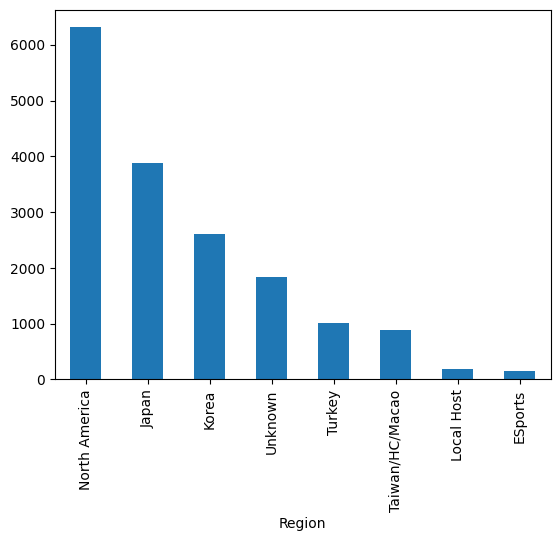

In [110]:
# bar plot the number of no_bans per region
no_bans = ban_data[ban_data['Champion'] == 'noBan']

no_bans['Region'].value_counts().plot(kind='bar')

# bar plot of the rate of no_bans per region, accounting for the number of matches in each region
region_counts = ban_data['Region'].value_counts()
no_ban_counts = no_bans['Region'].value_counts()

no_ban_rate = no_ban_counts / region_counts

no_ban_rate.sort_values(ascending=False).plot(kind='bar')

# as expected, Esports players are the best at remembering to ban champions since it gives them an advantage in the game


In [111]:
# create a bar chart of each region's top banned champions
valid_champs = ban_data[ban_data['Champion'] != 'noBan']

region_champs = valid_champs.groupby(['Region', 'Champion']).size().reset_index(name='counts')

region_champs = region_champs.sort_values(['Region', 'counts'], ascending=[True, False])

region_champs = region_champs.groupby('Region').head(5)

region_champs

,Region,Champion,counts
56,ESports,Leblanc,960
14,ESports,Camille,865
96,ESports,Syndra,771
22,ESports,Elise,762
121,ESports,Zac,757
149,Japan,Ryze,26
156,Japan,Trundle,24
159,Japan,Vladimir,19
133,Japan,Caitlyn,17
143,Japan,Kindred,17


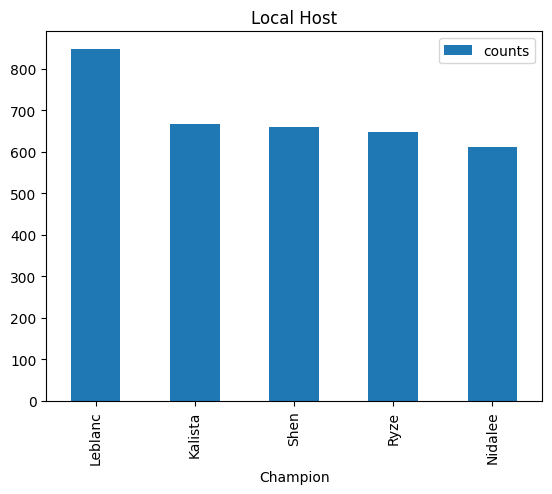

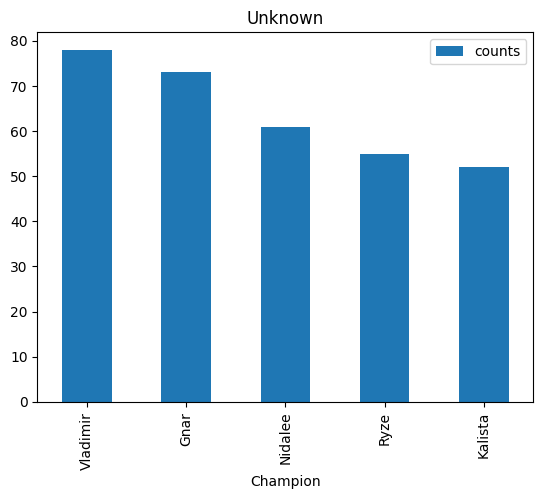

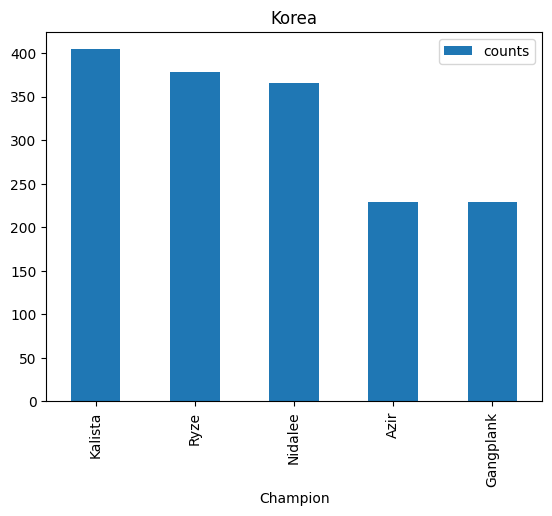

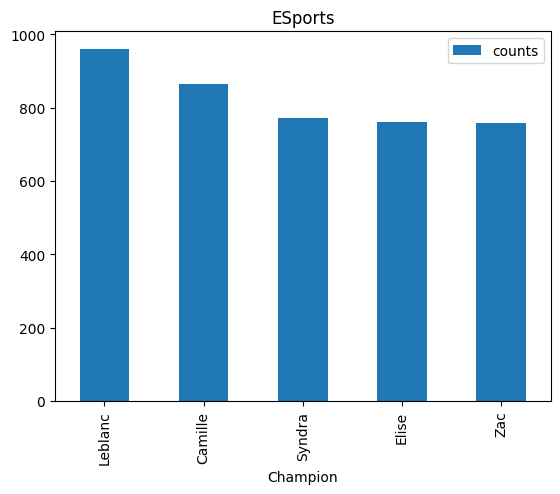

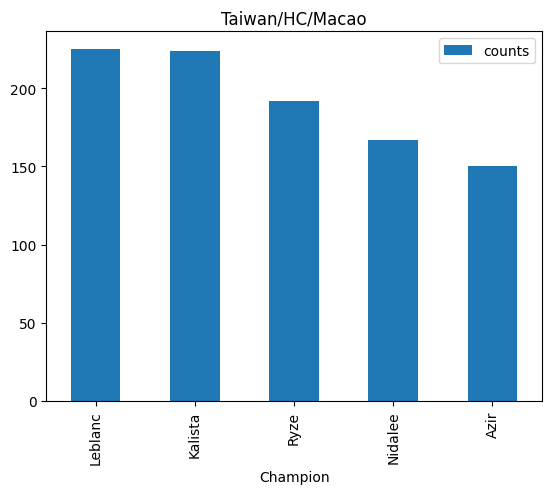

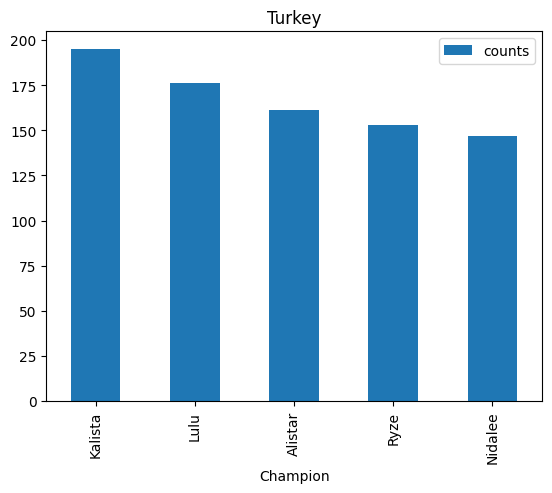

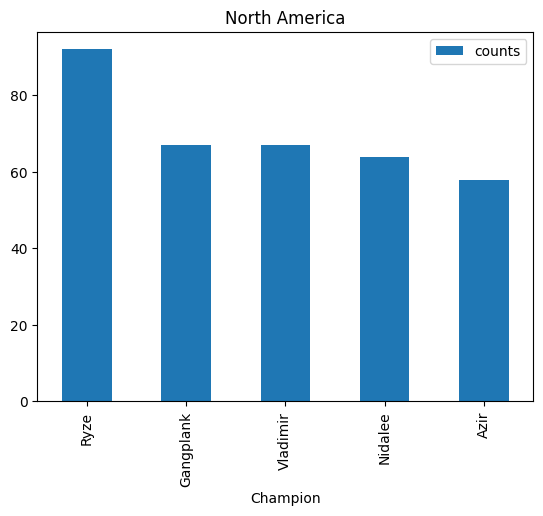

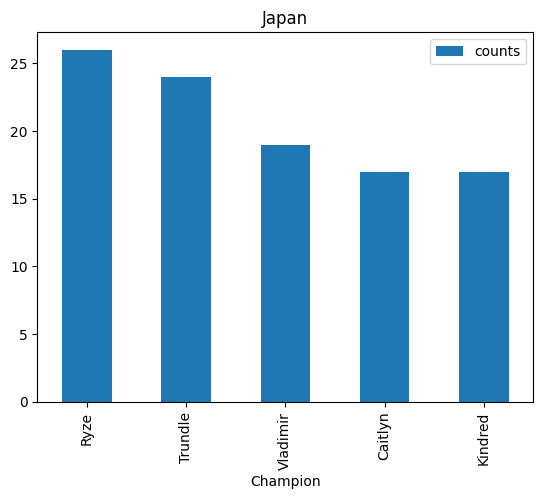

In [112]:
# create plots for each region of their most banned champions
for region in regions:
    region_champs[region_champs['Region'] == region].plot(kind='bar', x='Champion', title=region)

In [113]:
# create a new dataframe
imputing_df = ban_data[['Server', 'Region', 'URL_num', 'Champion']]
imputing_df = imputing_df[imputing_df['Champion'] != 'noBan']

In [114]:
# map the champions to integers from banned_champs
#imputing_df['Champion'] = imputing_df['Champion'].cat.set_categories(banned_champs)

# check the mapping
#imputing_df['Champion'].cat.codes

In [123]:
# convert Champion to categorical
imputing_df['Champion'] = imputing_df['Champion'].astype('category')

# convert others to categorical
imputing_df['Server'] = imputing_df['Server'].astype('category')
imputing_df['Region'] = imputing_df['Region'].astype('category')

imputing_df

,Server,Region,URL_num,Champion
0,11,3,30030.0,91
1,11,3,30054.0,50
2,11,3,30067.0,42
3,11,3,30091.0,6
4,11,3,30105.0,39
...,...,...,...,...
76195,2,0,530658.0,95
76196,2,0,530666.0,89
76197,2,0,520894.0,3
76198,2,0,520895.0,93


In [124]:
# convert Champion, Server, and Region to floats or bools that identify the string they're associated with

imputing_df['Champion'] = imputing_df['Champion'].astype('category').cat.codes
imputing_df['Server'] = imputing_df['Server'].astype('category').cat.codes
imputing_df['Region'] = imputing_df['Region'].astype('category').cat.codes

# I never should have chosen this all-strings dataset. I regret everything.
imputing_df

,Server,Region,URL_num,Champion
0,11,3,30030.0,91
1,11,3,30054.0,50
2,11,3,30067.0,42
3,11,3,30091.0,6
4,11,3,30105.0,39
...,...,...,...,...
76195,2,0,530658.0,95
76196,2,0,530666.0,89
76197,2,0,520894.0,3
76198,2,0,520895.0,93


In [121]:
# check for missing values
print(imputing_df.isnull().sum())

Server      0
Region      0
URL_num     0
Champion    0
dtype: int64


In [128]:
# get the target regions
target_regions = ['Korea', 'Taiwan/HC/Macao', 'Local Host']
chi_df = imputing_df[imputing_df['Region'].isin(target_regions)]

tab = pd.crosstab(chi_df['Champion'], chi_df['Region'])

if chi_df.empty:
    print('empty')
else:
    chi2, p, dof, expected = chi2_contingency(tab)

    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies:")
    print(expected)


First few rows of imputing_df:
   Server  Region  URL_num  Champion
0      11       3  30030.0        91
1      11       3  30054.0        50
2      11       3  30067.0        42
3      11       3  30091.0         6
4      11       3  30105.0        39
Unique values in the 'Region' column:
[3 7 2 0 5 6 4 1]
empty


ValueError: No data; `observed` has size 0.

In [248]:
# simple regression model
m = smf.ols('Champion ~ Server + Region + URL_num', data=imputing_df).fit()

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Champion   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     12.02
Date:                Sun, 29 Sep 2024   Prob (F-statistic):           7.26e-08
Time:                        19:56:53   Log-Likelihood:            -2.9876e+05
No. Observations:               59316   AIC:                         5.975e+05
Df Residuals:                   59312   BIC:                         5.976e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     63.5545      0.313    203.018      0.000      62.941      64.168
Server         0.2815      0.049      5.722      0.000       0.185       0.378
Region        -0.6984      0.143     -4.870      0.000      -0.979      -0.417
URL_num    -4.909e-10   3.28e-10     -1.495      0.135   -1.13e-09    1.53e-10
==============================================================================
Omnibus:                    27157.212   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3223.868
Skew:                           0.124   Prob(JB):                         0.00
Kurtosis:                       1.885   Cond. No.                     1.35e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [320]:
imputing_df['Champion'] = m.predict(imputing_df[['Server', 'Region', 'URL_num']])
imputing_df['Champion'] = imputing_df['Champion'].round().astype('int')

imputing_df['Champion'] = imputing_df['Champion'].astype('category')
imputing_df['Champion'] = imputing_df['Champion'].cat.codes
imputing_df['Champion'] = imputing_df['Champion'].astype('category')

imputing_df

,Server,Region,URL_num,Champion
0,11,3,30030.0,4
1,11,3,30054.0,4
2,11,3,30067.0,4
3,11,3,30091.0,4
4,11,3,30105.0,4
...,...,...,...,...
76195,2,0,530658.0,3
76196,2,0,530666.0,3
76197,2,0,520894.0,3
76198,2,0,520895.0,3
